In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
%matplotlib inline
import pyodbc
con = pyodbc.connect('DSN=ISDW')
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Code to Pull Top 5 chips for SCF

In [2]:
daysback = 500

datesettings = """
and last_test_date > CURRENT_DATE - {} days
--and last_test_date between '2020-02-16' and '2020-03-01'
""".format(daysback)

SQLQuery = """
select lot_id_base, wafer_id, family_code, corner, sum(SCF_COUNT) as top5_SCF_count
from
(
select tw.lot_id, substr(tw.lot_id,1,9) as lot_id_base, tw.wafer_id, tw.family_code, 
corner, prc.categoryName as parameter, count,
tc.normalized_TestX as chipX, tc.normalized_TestY as chipY,
case 
    when prc.categoryName = 'SCF' then count
    else 0
end as SCF_COUNT
from
    DMIW.PattRecChipFactR prcfr
    join DMIW_SYSTEMS.DERIVEDDATASETUP dds  on prcfr.derivedsetupkey = dds.derivedsetupkey
    join DMIW_SYSTEMS.PATTRECCATEGORY prc   on prcfr.pattRecCatKey = prc.pattRecCatKey
    join DMIW_SYSTEMS.TESTEDWAFER tw        on prcfr.testedwaferkey = tw.testedwaferkey
    join DMIW_SYSTEMS.TESTEDCHIP tc         on prcfr.testedwaferkey = tc.testedwaferkey and prcfr.testedchipkey = tc.testedchipkey
    join DMIW_SYSTEMS.GEOGRAPHY g           on prcfr.geographykey = g.geographykey
where
    tw.testedwaferkey is not null and
    categoryName <> '' and exclude_Flag = 'N' and
    corner in ('M7060P060ATPA', 'M7125P125ATPA') and
    tc.normalized_testx || '_' || tc.normalized_testy in ('88_92','60_92','116_81','74_81','46_81')
    {}
order by lot_Id, wafer_Id, tc.normalized_TestX, tc.normalized_TestY, parameter, count
)
GROUP BY lot_id_base, wafer_id, family_code, corner
""".format(datesettings)

df = pd.read_sql(SQLQuery,con)

In [3]:
df = pd.pivot_table(df, values=['TOP5_SCF_COUNT'], index = ['LOT_ID_BASE', 'WAFER_ID', 'FAMILY_CODE'], columns= ['CORNER'], aggfunc=np.mean)

## Code to Pull Top 2 chips for SCF

In [4]:
SQLQuery = """
select lot_id_base, wafer_id, family_code, corner, sum(SCF_COUNT) as top2_SCF_count
from
(
select tw.lot_id, substr(tw.lot_id,1,9) as lot_id_base, tw.wafer_id, tw.family_code, 
corner, prc.categoryName as parameter, count,
tc.normalized_TestX as chipX, tc.normalized_TestY as chipY,
case 
    when prc.categoryName = 'SCF' then count
    else 0
end as SCF_COUNT
from
    DMIW.PattRecChipFactR prcfr
    join DMIW_SYSTEMS.DERIVEDDATASETUP dds  on prcfr.derivedsetupkey = dds.derivedsetupkey
    join DMIW_SYSTEMS.PATTRECCATEGORY prc   on prcfr.pattRecCatKey = prc.pattRecCatKey
    join DMIW_SYSTEMS.TESTEDWAFER tw        on prcfr.testedwaferkey = tw.testedwaferkey
    join DMIW_SYSTEMS.TESTEDCHIP tc         on prcfr.testedwaferkey = tc.testedwaferkey and prcfr.testedchipkey = tc.testedchipkey
    join DMIW_SYSTEMS.GEOGRAPHY g           on prcfr.geographykey = g.geographykey
where
    tw.testedwaferkey is not null and
    categoryName <> '' and exclude_Flag = 'N' and
    corner in ('M7060P060ATPA', 'M7125P125ATPA') and
    tc.normalized_testx || '_' || tc.normalized_testy in ('88_92','60_92')
    {}
order by lot_Id, wafer_Id, tc.normalized_TestX, tc.normalized_TestY, parameter, count
)
GROUP BY lot_id_base, wafer_id, family_code, corner
""".format(datesettings)

df1 = pd.read_sql(SQLQuery,con)

In [5]:
df1 = pd.pivot_table(df1, values=['TOP2_SCF_COUNT'], index = ['LOT_ID_BASE', 'WAFER_ID', 'FAMILY_CODE'], columns= ['CORNER'], aggfunc=np.mean)

In [6]:
data = df.join(df1)

In [7]:
data.head()

TOP5_SCF_COUNT                \
CORNER                                M7060P060ATPA M7125P125ATPA   
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                
8IQU19003   65700WANSED6 9S                     0.0           0.0   
            6570123RSEF2 9S                     0.0           0.0   
            6570123TSEG3 9S                     0.0           0.0   
            6570123VSEA1 9S                     0.0           0.0   
            6570123XSEB2 9S                     0.0           0.0   

                                     TOP2_SCF_COUNT                
CORNER                                M7060P060ATPA M7125P125ATPA  
LOT_ID_BASE WAFER_ID     FAMILY_CODE                               
8IQU19003   65700WANSED6 9S                     0.0           0.0  
            6570123RSEF2 9S                     0.0           0.0  
            6570123TSEG3 9S                     0.0           0.0  
            6570123VSEA1 9S                     0.0           0.0  
            6570123XSEB2 9S                     0.0           0.0

## Pull data for TP143 Vmin Yield

In [8]:
daysback = 365

SQLQuery2 = """
select lot_Id_base, wafer_Id, family_Code,
sum(tp_vmax) as tp_vmax, sum(tp_vmin) as tp_vmin
from
(
    select left(lot_Id, 9) as lot_id_base, wafer_Id, family_Code, date,
        sample_Size - screened - n_Censored_Low - n_Censored_High as n,
        case when parm_Label = 'DI56_C5_125P125A_ST_TP_2M_Perfect' then yield else null end as tp_vmax,
        case when parm_Label = 'DI56_C5_060P060A_ST_TP_2M_Perfect' then yield else null end as tp_vmin
    from DMIW.PTileWaferFact pTileWaferFact, 
        DMIW_SYSTEMS.TestParm testParm, 
        (select testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade as lot_Grade, last_TestTimeStamp as date, level, last_Eqp_Id 
        from DMIW_SYSTEMS.TestedWafer testedWafer 
        where Tech_id = '5H 14HP' and Level = 'C5'
        and (Calcdefs = 'DI511' or  Calcdefs = 'DI561')
        {}
        ) testedWafer 
    where testedWafer.testedWaferKey = pTileWaferFact.testedWaferKey and 
        testParm.testParmKey = pTileWaferFact.testParmKey 
        and weighted_Mean is not null and abs(weighted_Mean) < 1e25
        and parm_Label in ('DI56_C5_125P125A_ST_TP_2M_Perfect', 'DI56_C5_060P060A_ST_TP_2M_Perfect')
) DGyields
group by lot_Id_base, wafer_Id, family_Code, date, n
order by lot_Id_base, wafer_Id 
""".format(datesettings)

In [9]:
df2 = pd.read_sql(SQLQuery2,con)

In [10]:
data = data.join(df2.set_index(['LOT_ID_BASE','WAFER_ID','FAMILY_CODE']))

/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [11]:
data['YLD_DELTA'] = data['TP_VMAX'] - data['TP_VMIN']

In [12]:
data.head()

(TOP5_SCF_COUNT, M7060P060ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU19003   65700WANSED6 9S                                       0.0   
            6570123RSEF2 9S                                       0.0   
            6570123TSEG3 9S                                       0.0   
            6570123VSEA1 9S                                       0.0   
            6570123XSEB2 9S                                       0.0   

                                      (TOP5_SCF_COUNT, M7125P125ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU19003   65700WANSED6 9S                                       0.0   
            6570123RSEF2 9S                                       0.0   
            6570123TSEG3 9S                                       0.0   
            6570123VSEA1 9S                                       0.0   
            6570123XSEB2 9S                                       0.0   

                                      (TOP2_SCF_COUNT, M7060P060ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU19003   65700WANSED6 9S                                       0.0   
            6570123RSEF2 9S                                       0.0   
            6570123TSEG3 9S                                       0.0   
            6570123VSEA1 9S                                       0.0   
            6570123XSEB2 9S                                       0.0   

                                      (TOP2_SCF_COUNT, M7125P125ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU19003   65700WANSED6 9S                                       0.0   
            6570123RSEF2 9S                                       0.0   
            6570123TSEG3 9S                                       0.0   
            6570123VSEA1 9S                                       0.0   
            6570123XSEB2 9S                                       0.0   

                                      TP_VMAX  TP_VMIN  YLD_DELTA  
LOT_ID_BASE WAFER_ID     FAMILY_CODE                               
8IQU19003   65700WANSED6 9S             97.22    97.22        0.0  
            6570123RSEF2 9S            100.00   100.00        0.0  
            6570123TSEG3 9S             97.22    97.22        0.0  
            6570123VSEA1 9S             97.22    97.22        0.0  
            6570123XSEB2 9S            100.00   100.00        0.0

## PG ION

In [13]:
SQLQuery3 = """
SELECT LEFT(lot_Id,9) AS lot_id_base, wafer_Id, weighted_Mean as SLK_D102_PG_M1_Ion_Mean
FROM DMIW.PTileWaferFact ptilewf
JOIN DMIW_SYSTEMS.TestParm tp ON ptilewf.testParmKey = tp.testParmKey
JOIN DMIW_SYSTEMS.TestedWafer tw ON ptilewf.testedWaferKey = tw.testedWaferKey
WHERE Tech_id = '5H 14HP'
{}
and weighted_Mean is not null and abs(weighted_Mean) < 1e25 
and ( ucase(tp.parm_Label) like 'SLK_D102_PG_M1_ION' )  
order by lot_Id, wafer_Id 
""".format(datesettings)

In [41]:
asfd = pd.read_sql(SQLQuery3,con)

In [42]:
asfd

,LOT_ID_BASE,WAFER_ID,SLK_D102_PG_M1_ION_MEAN
0,8IQU19003,65700WANSED6,93.908875
1,8IQU19003,6570123RSEF2,90.326752
2,8IQU19003,6570123TSEG3,91.217751
3,8IQU19003,6570123VSEA1,91.195747
4,8IQU19003,6570123XSEB2,92.435501
...,...,...,...
8352,8IQV39000,6A09M154SOE5,87.788628
8353,8IQV39000,6A09M155SOB4,91.370499
8354,8IQV39000,6A09M156SOF6,90.038750
8355,8IQV39000,6A09M162SOA5,91.092125


## For Training the Random Forest Classifier

In [14]:
training = pd.read_csv('data/tp143.csv')

In [15]:
training = training.dropna()

In [16]:
training = training.set_index(['LOT_ID_BASE','WAFER_ID','FAMILY_CODE'])

In [17]:
training

('TOP5_SCF_COUNT', 'M7060P060ATPA')  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                        
8IQU08008   65700N26SEE3 US                                          29.0   
            65700N27SEB2 US                                          16.0   
            65700N2BSED6 US                                          11.0   
            65700N2DSEE7 US                                           0.0   
            65700N35SEE5 US                                           1.0   
...                                                                   ...   
8IQU44011   6580037YSEC0 9S                                          36.0   
8IQU44017   6580038XSEC2 9S                                         136.0   
            65800391SED2 9S                                          45.0   
            6580039ASEE7 9S                                          17.0   
8IQU44021   658008AUSED4 TM                                           1.0   

                                      ('TOP5_SCF_COUNT', 'M7125P125ATPA')  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                        
8IQU08008   65700N26SEE3 US                                          27.0   
            65700N27SEB2 US                                          11.0   
            65700N2BSED6 US                                          10.0   
            65700N2DSEE7 US                                           0.0   
            65700N35SEE5 US                                           0.0   
...                                                                   ...   
8IQU44011   6580037YSEC0 9S                                           0.0   
8IQU44017   6580038XSEC2 9S                                           0.0   
            65800391SED2 9S                                           0.0   
            6580039ASEE7 9S                                           0.0   
8IQU44021   658008AUSED4 TM                                           0.0   

                                      ('TOP2_SCF_COUNT', 'M7060P060ATPA')  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                        
8IQU08008   65700N26SEE3 US                                          19.0   
            65700N27SEB2 US                                          16.0   
            65700N2BSED6 US                                          11.0   
            65700N2DSEE7 US                                           0.0   
            65700N35SEE5 US                                           1.0   
...                                                                   ...   
8IQU44011   6580037YSEC0 9S                                          34.0   
8IQU44017   6580038XSEC2 9S                                         132.0   
            65800391SED2 9S                                          45.0   
            6580039ASEE7 9S                                          14.0   
8IQU44021   658008AUSED4 TM                                           1.0   

                                      ('TOP2_SCF_COUNT', 'M7125P125ATPA')  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                        
8IQU08008   65700N26SEE3 US                                          19.0   
            65700N27SEB2 US                                          11.0   
            65700N2BSED6 US                                          10.0   
            65700N2DSEE7 US                                           0.0   
            65700N35SEE5 US                                           0.0   
...                                                                   ...   
8IQU44011   6580037YSEC0 9S                                           0.0   
8IQU44017   6580038XSEC2 9S                                           0.0   
            65800391SED2 9S                                           0.0   
            6580039ASEE7 9S                                           0.0   
8IQU44021   658008AUSED4 TM                                           0.0   

                              

In [30]:
# Random Forest Classifier
X,y = training.loc[:,training.columns != 'Label'], training['Label']
clf = ensemble.RandomForestClassifier(n_jobs=-1)

# Gridsearch CV
parameter_grid = {'max_depth' : np.arange(5,12,1),
                  'n_estimators' : np.arange(200,250,10),
                  'criterion' : ['gini', 'entropy'],
                  'class_weight' : [None, 'balanced']
                 }

grid_search = model_selection.GridSearchCV(clf,parameter_grid)
grid_search.fit(X,y)
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

average accuracy score: 0.9731493506493507


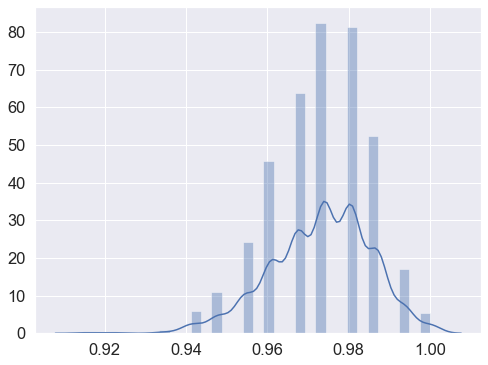

In [31]:
# Model Accuracy
# take the best model from the grid search and split it randomly x times to test for the accuracy
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=0.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [ ]:
def find_model_accuracy(train_data, train_labels, test_data, test_labels, model):
    # Fit the model to the training set
    model.fit(train_data, train_labels)
    test_predict = model.predict(test_data)
    
    # plot_confusion matrix
    sns.heatmap(metrics.confusion_matrix(test_labels, test_predict), 
                xticklabels=['pred: Neg', 'pred: Pos'],
                annot=True,
                fmt='g',
                cmap='Blues').set_yticklabels(['actual: Neg', 'actual: Pos'], rotation=0)
    plt.tight_layout()

    plt.show()
    # return accuracy
    return metrics.accuracy_score(test_predict, test_labels), test_predict, test_labels

In [ ]:
X,y = training.loc[:,training.columns != 'Label'], training['Label']
# Split Train and Test Sets
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2)

In [ ]:
# Quick Model RandomForestClassifier
X,y = train_data, train_labels
model = ensemble.RandomForestClassifier(class_weight=None, criterion='entropy',
                                            max_depth=7, n_estimators=230, n_jobs=-1)
accuracy, predict, actual = find_model_accuracy(X, y, test_data, test_labels, model)
model.fit(X, y)
print(accuracy)

In [ ]:
# Create a dataframe showing all the mistakes made by the classifier
fail_analysis = actual.to_frame()
fail_analysis['predicted'] = predict

In [ ]:
fail_analysis[fail_analysis.Label != fail_analysis.predicted]

In [18]:
# Quick Model RandomForestClassifier
X,y = training.loc[:,training.columns != 'Label'], training['Label']
model = ensemble.RandomForestClassifier(class_weight=None, criterion='entropy',
                                            max_depth=7, n_estimators=230, n_jobs=-1)
#accuracy, predict, actual = find_model_accuracy(X, y, test_data, test_labels, model)
model.fit(X, y)
#print(accuracy)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=230,
                       n_jobs=-1)

In [19]:
data = data.dropna()

In [20]:
data['predict'] = model.predict(X=data)

In [27]:
pd.set_option('display.max_rows', 1000)
data[data.predict==1]

(TOP5_SCF_COUNT, M7060P060ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU19002   65800395SEF4 TM                                       4.0   
8IQU21009   6A08F095SOA0 TM                                     174.0   
8IQU26001   6A07C176SOF0 9S                                       4.0   
8IQU28002   6A07B194SOF1 9S                                       8.0   
            6A07C362SOD7 9S                                       6.0   
8IQU28012   6570138ESEB1 9S                                     128.0   
            6580018CSED2 9S                                      38.0   
8IQU29005   6A084226SOB1 US                                      10.0   
            6A084227SOF3 US                                       6.0   
            6A084274SOA3 US                                     124.0   
            6A08A155SOB3 US                                      58.0   
            6A08A156SOF5 US                                     236.0   
            6A08A157SOC4 US                                      78.0   
            6A08A158SOG6 US                                      10.0   
            6A08A163SOE6 US                                      28.0   
            6A08A164SOB5 US                                    1826.0   
            6A08A170SOD7 US                                      10.0   
            6A08A197SOF6 US                                      10.0   
            6A08B181SOF5 US                                      11.0   
8IQU29013   6A08C266SOC5 TM                                       4.0   
8IQU31006   6A07M105SOC4 US                                      93.0   
            6A07S105SOE6 US                                      10.0   
8IQU31007   6A081276SOA3 9S                                       6.0   
8IQU31015   6A07M091SOE6 US                                      47.0   
            6A07R218SOG0 US                                      35.0   
            6A07R274SOB2 US                                    1020.0   
8IQU31018   6A08I116SOF3 US                                      48.0   
8IQU31019   6A07R226SOC0 9S                                       8.0   
8IQU31022   6A07S035SOE3 9S                                     989.0   
            6A07S036SOB2 9S                                    1371.0   
            6A089184SOA2 9S                                       6.0   
            6A089187SOF5 9S                                     264.0   
            6A089188SOC4 9S                                      11.0   
            6A089190SOC4 9S                                     796.0   
            6A089193SOA4 9S                                    1977.0   
            6A089195SOB5 9S                                      13.0   
            6A089199SOD7 9S                                     117.0   
            6A089202SOG4 9S                                     212.0   
8IQU31027   6A081216SOC7 9S                                    3786.0   
8IQU31030   6580019DSEE5 9S                                       8.0   
            6580019MSEG0 9S                                     174.0   
            658001AGSEB6 9S                                       5.0   
8IQU32001   6A084231SOG4 US                                      68.0   
            6A084234SOE4 US                                     114.0   
            6A084235SOB3 US                                    1658.0   
            6A087207SOE7 US                                      96.0   
            6A087210SOB6 US                                       4.0   
            6A087249SOB7 US                                     290.0   
            6A088068SOB3 US                                       7.0   
8IQU32002   6A07K028SOC2 9S                                      22.0   
8IQU32011   6A07P004SOA2 9S                                      10.0   
8IQU32012   6A07V222SOB2 US                                      24.0   
8IQU32016   6A08C089SOE0 9S                                      12.0   
            6A08C104SOE

In [21]:
data.to_csv("/Users/acyang@us.ibm.com/Downloads/TP143Signal.csv")

In [45]:
data

(TOP5_SCF_COUNT, M7060P060ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU18011   6A068022SOD4 US                                       0.0   
            6A06G352SOF2 US                                       0.0   
            6A06H269SOD7 US                                       0.0   
            6A06J153SOF0 US                                       3.0   
            6A06J154SOB7 US                                       0.0   
...                                                               ...   
8IQV37008   6A09N105SOB4 US                                       0.0   
            6A09N109SOD6 US                                       0.0   
            6A09N110SOG7 US                                       0.0   
            6A09N137SOB3 US                                       0.0   
8IQV37009   6A09K164SOB0 US                                       0.0   

                                      (TOP5_SCF_COUNT, M7125P125ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU18011   6A068022SOD4 US                                       0.0   
            6A06G352SOF2 US                                       0.0   
            6A06H269SOD7 US                                       0.0   
            6A06J153SOF0 US                                       0.0   
            6A06J154SOB7 US                                       0.0   
...                                                               ...   
8IQV37008   6A09N105SOB4 US                                       0.0   
            6A09N109SOD6 US                                       0.0   
            6A09N110SOG7 US                                       0.0   
            6A09N137SOB3 US                                       0.0   
8IQV37009   6A09K164SOB0 US                                       0.0   

                                      (TOP2_SCF_COUNT, M7060P060ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU18011   6A068022SOD4 US                                       0.0   
            6A06G352SOF2 US                                       0.0   
            6A06H269SOD7 US                                       0.0   
            6A06J153SOF0 US                                       3.0   
            6A06J154SOB7 US                                       0.0   
...                                                               ...   
8IQV37008   6A09N105SOB4 US                                       0.0   
            6A09N109SOD6 US                                       0.0   
            6A09N110SOG7 US                                       0.0   
            6A09N137SOB3 US                                       0.0   
8IQV37009   6A09K164SOB0 US                                       0.0   

                                      (TOP2_SCF_COUNT, M7125P125ATPA)  \
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                    
8IQU18011   6A068022SOD4 US                                       0.0   
            6A06G352SOF2 US                                       0.0   
            6A06H269SOD7 US                                       0.0   
            6A06J153SOF0 US                                       0.0   
            6A06J154SOB7 US                                       0.0   
...                                                               ...   
8IQV37008   6A09N105SOB4 US                                       0.0   
            6A09N109SOD6 US                                       0.0   
            6A09N110SOG7 US                                       0.0   
            6A09N137SOB3 US                                       0.0   
8IQV37009   6A09K164SOB0 US                                       0.0   

                                      TP_VMAX  TP_VMIN  YLD_DELTA  predict  
LOT_ID_BASE WAFER_ID     FAMILY_CODE                                        
8IQU18011   6A068022SOD4 US            100.00   100.00       0.00      0.0  
       

In [47]:
data.reset_index()[data.reset_index()['LOT_ID_BASE'] == '8IQV36011']

,LOT_ID_BASE,WAFER_ID,FAMILY_CODE,"(TOP5_SCF_COUNT, M7060P060ATPA)","(TOP5_SCF_COUNT, M7125P125ATPA)","(TOP2_SCF_COUNT, M7060P060ATPA)","(TOP2_SCF_COUNT, M7125P125ATPA)",TP_VMAX,TP_VMIN,YLD_DELTA,predict
18799,8IQV36011,6A09Y159SOA7,US,5.0,0.0,3.0,0.0,100.00,80.55,19.45,0.0
18800,8IQV36011,6A09Y160SOE0,US,4.0,0.0,2.0,0.0,97.22,91.66,5.56,0.0
18801,8IQV36011,6A09Y161SOA7,US,108.0,0.0,108.0,0.0,100.00,88.88,11.12,1.0
18802,8IQV36011,6A09Y163SOC0,US,1.0,0.0,0.0,0.0,100.00,94.44,5.56,0.0
18803,8IQV36011,6A09Y164SOG2,US,21.0,0.0,16.0,0.0,100.00,52.77,47.23,1.0
18804,8IQV36011,6A09Y165SOD1,US,1.0,0.0,1.0,0.0,94.44,88.88,5.56,0.0
18805,8IQV36011,6A09Y166SOA0,US,45.0,0.0,44.0,0.0,97.22,75.00,22.22,1.0
18806,8IQV36011,6A09Y167SOE2,US,9.0,0.0,9.0,0.0,97.22,91.66,5.56,1.0
18807,8IQV36011,6A09Z074SOE5,US,0.0,0.0,0.0,0.0,100.00,97.22,2.78,0.0
18808,8IQV36011,6A09Z076SOF6,US,19.0,0.0,14.0,0.0,100.00,61.11,38.89,1.0


## Pull metrology data related to Fin Pitch Walk

In [46]:
sql = """
-- sql for MEASUREMENTSUM retrieval 
select lot_Id, wafer_Id, family_Code, date, 
  --meas_Pd_Id || ' ' || meas_Eqp_Id as tool, 
  meas_Pd_Id || ' ' || dcItem_Name as parameter,
  dcItem_Value as mean
from DMIW.MeasuredFact measuredFact, 
  DMIW_SYSTEMS.MeasuredParm measuredParm, 
  (select measuredWaferKey, lot_Id, meas_Wafer_Id as wafer_Id, family_Code, lot_Grade, measurement_Date as date, proc_Level, meas_Pd_Id, meas_Eqp_Id 
  from DMIW_SYSTEMS.MeasuredWafer measuredWafer 
  where Measurement_date >= (current date - 500 days) and Tech_id = '5H 14HP' and Meas_pd_id in ('MEACDRIEMDL5FNP.1', 'MEASOIMDRL5FNP.1', 'MTRMANDRELVE5FNP.1') 
  group by measuredWaferKey, lot_Id, meas_Wafer_Id, family_Code, lot_Grade, measurement_Date, proc_Level, meas_pd_Id, meas_Eqp_Id) measuredWafer 
where measuredWafer.measuredWaferKey = measuredFact.measuredWaferKey and 
  measuredParm.measuredParmKey = measuredFact.measuredParmKey and 
  measuredParm.dcItem_Meas_Type = 'Wafer' and 
  meas_Pd_Id <> '' and dcItem_Value is not null and 
  ucase(dcItem_Name) not in ('WMDIESIZEX', 'WMDIESIZEY') 
 order by lot_Id, wafer_Id, dcItem_Name, proc_Level 
;
"""
met_df = pd.read_sql(sql,con)

In [47]:
met_df

,LOT_ID,WAFER_ID,FAMILY_CODE,DATE,PARAMETER,MEAN
0,18225H9S005.000,6A06Q033SOG7,9S,2018-11-22,MEACDRIEMDL5FNP.1 G01 CellType,1.000000
1,18225H9S005.000,6A06Q033SOG7,9S,2018-11-22,MEACDRIEMDL5FNP.1 G01 P01H,0.996193
2,18225H9S005.000,6A06Q033SOG7,9S,2018-11-22,MEACDRIEMDL5FNP.1 G01 P01L,0.995508
3,18225H9S005.000,6A06Q033SOG7,9S,2018-11-22,MEACDRIEMDL5FNP.1 G01 P01R,0.000685
4,18225H9S005.000,6A06Q033SOG7,9S,2018-11-22,MEACDRIEMDL5FNP.1 G01 P01S,0.000221
...,...,...,...,...,...,...
198805,20045HUS002.000,6A09W226SOC4,US,2020-02-26,MTRMANDRELVE5FNP.1 W_XLS_CD1_Std,0.352700
198806,20045HUS002.000,6A09W226SOC4,US,2020-02-26,MTRMANDRELVE5FNP.1 W_XLS_LWR1_Mean,3.695960
198807,20045HUS002.000,6A09W226SOC4,US,2020-02-26,MTRMANDRELVE5FNP.1 W_XLS_LWR1_Std,0.102060
198808,20045HUS002.000,6A09W226SOC4,US,2020-02-26,MTRMANDRELVE5FNP.1 XLS CD1 W Std,0.352703


In [51]:
met_df = pd.pivot_table(met_df, values=['MEAN'], index = ['WAFER_ID'], columns= ['PARAMETER'], aggfunc=np.mean)

In [52]:
met_df

MEAN                             \
PARAMETER    MEACDRIEMDL5FNP.1 G01 CellType MEACDRIEMDL5FNP.1 G01 P01H   
WAFER_ID                                                                 
65700H2ESEH0                            1.0                   0.996799   
65700H2GSEA6                            1.0                   0.996653   
65700H3GSEF2                            NaN                        NaN   
65700H3LSEE3                            NaN                        NaN   
65700H3PSEG5                            1.0                   0.995896   
...                                     ...                        ...   
6A09Y089SOA4                            NaN                        NaN   
6A09Y096SOH0                            NaN                        NaN   
6A09Y102SOA2                            NaN                        NaN   
6A09Y103SOE4                            NaN                        NaN   
6A09Y125SOH2                            NaN                        NaN   

                                                                    \
PARAMETER    MEACDRIEMDL5FNP.1 G01 P01L MEACDRIEMDL5FNP.1 G01 P01R   
WAFER_ID                                                             
65700H2ESEH0                   0.996201                   0.000598   
65700H2GSEA6                   0.996210                   0.000443   
65700H3GSEF2                        NaN                        NaN   
65700H3LSEE3                        NaN                        NaN   
65700H3PSEG5                   0.995023                   0.000872   
...                                 ...                        ...   
6A09Y089SOA4                        NaN                        NaN   
6A09Y096SOH0                        NaN                        NaN   
6A09Y102SOA2                        NaN                        NaN   
6A09Y103SOE4                        NaN                        NaN   
6A09Y125SOH2                        NaN                        NaN   

                                                                    \
PARAMETER    MEACDRIEMDL5FNP.1 G01 P01S MEACDRIEMDL5FNP.1 G01 P01X   
WAFER_ID                                                             
65700H2ESEH0                   0.000152                   0.996525   
65700H2GSEA6                   0.000130                   0.996459   
65700H3GSEF2                        NaN                        NaN   
65700H3LSEE3                        NaN                        NaN   
65700H3PSEG5                   0.000245                   0.995542   
...                                 ...                        ...   
6A09Y089SOA4                        NaN                        NaN   
6A09Y096SOH0                        NaN                        NaN   
6A09Y102SOA2                        NaN                        NaN   
6A09Y103SOE4                        NaN                        NaN   
6A09Y125SOH2                        NaN                        NaN   

                                                                    \
PARAMETER    MEACDRIEMDL5FNP.1 G01 P02H MEACDRIEMDL5FNP.1 G01 P02L   
WAFER_ID                                                             
65700H2ESEH0                   0.000040                   0.000034   
65700H2GSEA6                   0.000041                   0.000035   
65700H3GSEF2                        NaN                        NaN   
65700H3LSEE3                        NaN                        NaN   
65700H3PSEG5                   0.000060                   0.000049   
...                                 ...                        ...   
6A09Y089SOA4                        NaN                        NaN   
6A09Y096SOH0                        NaN                        NaN   
6A09Y102SOA2                        NaN                        NaN   
6A09Y103SOE4                        NaN                        NaN   
6A09Y125SOH2                        NaN                        NaN   

                                                           

In [101]:
data = data.reset_index()
data = pd.DataFrame({'WAFER_ID':data.WAFER_ID, 'predict':data.predict})

In [116]:
out = pd.merge(met_df, data, on='WAFER_ID', how='inner')

/Users/acyang@us.ibm.com/anaconda3/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [123]:
out.columns = ['WAFER_ID']+[out.columns[i][1] for i in range(1,len(out.columns)-1)]+['predict']

In [124]:
out

,WAFER_ID,MEACDRIEMDL5FNP.1 G01 CellType,MEACDRIEMDL5FNP.1 G01 P01H,MEACDRIEMDL5FNP.1 G01 P01L,MEACDRIEMDL5FNP.1 G01 P01R,MEACDRIEMDL5FNP.1 G01 P01S,MEACDRIEMDL5FNP.1 G01 P01X,MEACDRIEMDL5FNP.1 G01 P02H,MEACDRIEMDL5FNP.1 G01 P02L,MEACDRIEMDL5FNP.1 G01 P02R,MEACDRIEMDL5FNP.1 G01 P02S,MEACDRIEMDL5FNP.1 G01 P02X,MEACDRIEMDL5FNP.1 G01 P11H,MEACDRIEMDL5FNP.1 G01 P11L,MEACDRIEMDL5FNP.1 G01 P11R,MEACDRIEMDL5FNP.1 G01 P11S,MEACDRIEMDL5FNP.1 G01 P11X,MEACDRIEMDL5FNP.1 G01 P12H,MEACDRIEMDL5FNP.1 G01 P12L,MEACDRIEMDL5FNP.1 G01 P12R,MEACDRIEMDL5FNP.1 G01 P12S,MEACDRIEMDL5FNP.1 G01 P12X,MEACDRIEMDL5FNP.1 G01 P13H,MEACDRIEMDL5FNP.1 G01 P13L,MEACDRIEMDL5FNP.1 G01 P13R,MEACDRIEMDL5FNP.1 G01 P13S,MEACDRIEMDL5FNP.1 G01 P13X,MEACDRIEMDL5FNP.1 G01 P14H,MEACDRIEMDL5FNP.1 G01 P14L,MEACDRIEMDL5FNP.1 G01 P14R,MEACDRIEMDL5FNP.1 G01 P14S,MEACDRIEMDL5FNP.1 G01 P14X,MEACDRIEMDL5FNP.1 G01 P15H,MEACDRIEMDL5FNP.1 G01 P15L,MEACDRIEMDL5FNP.1 G01 P15R,MEACDRIEMDL5FNP.1 G01 P15S,MEACDRIEMDL5FNP.1 G01 P15X,MEACDRIEMDL5FNP.1 G01 P16H,MEACDRIEMDL5FNP.1 G01 P16L,MEACDRIEMDL5FNP.1 G01 P16R,MEACDRIEMDL5FNP.1 G01 P16S,MEACDRIEMDL5FNP.1 G01 P16X,MEACDRIEMDL5FNP.1 G01 P17H,MEACDRIEMDL5FNP.1 G01 P17L,MEACDRIEMDL5FNP.1 G01 P17R,MEACDRIEMDL5FNP.1 G01 P17S,MEACDRIEMDL5FNP.1 G01 P17X,MEACDRIEMDL5FNP.1 G01 P18H,MEACDRIEMDL5FNP.1 G01 P18L,MEACDRIEMDL5FNP.1 G01 P18R,MEACDRIEMDL5FNP.1 G01 P18S,MEACDRIEMDL5FNP.1 G01 P18X,MEACDRIEMDL5FNP.1 G01 P19H,MEACDRIEMDL5FNP.1 G01 P19L,MEACDRIEMDL5FNP.1 G01 P19R,MEACDRIEMDL5FNP.1 G01 P19S,MEACDRIEMDL5FNP.1 G01 P19X,MEASOIMDRL5FNP.1 APC_W_L1_Thk_Max,MEASOIMDRL5FNP.1 APC_W_L1_Thk_Min,MEASOIMDRL5FNP.1 APC_W_L1_Thk_Rnge,MEASOIMDRL5FNP.1 APC_W_L2_Thk_Max,MEASOIMDRL5FNP.1 APC_W_L2_Thk_Min,MEASOIMDRL5FNP.1 APC_W_L2_Thk_Rnge,MEASOIMDRL5FNP.1 APC_W_L3_Thk_Max,MEASOIMDRL5FNP.1 APC_W_L3_Thk_Min,MEASOIMDRL5FNP.1 APC_W_L3_Thk_Rnge,MEASOIMDRL5FNP.1 APC_W_L4_Thk_Max,MEASOIMDRL5FNP.1 APC_W_L4_Thk_Min,MEASOIMDRL5FNP.1 APC_W_L4_Thk_Rnge,MEASOIMDRL5FNP.1 GOF Max,MEASOIMDRL5FNP.1 GOF Mean,MEASOIMDRL5FNP.1 GOF Min,MEASOIMDRL5FNP.1 GOF Std,MEASOIMDRL5FNP.1 L1 Thk Max,MEASOIMDRL5FNP.1 L1 Thk Mean,MEASOIMDRL5FNP.1 L1 Thk Min,MEASOIMDRL5FNP.1 L1 Thk Std,MEASOIMDRL5FNP.1 L2 Thk Max,MEASOIMDRL5FNP.1 L2 Thk Mean,MEASOIMDRL5FNP.1 L2 Thk Min,MEASOIMDRL5FNP.1 L2 Thk Std,MEASOIMDRL5FNP.1 L3 Thk Max,MEASOIMDRL5FNP.1 L3 Thk Mean,MEASOIMDRL5FNP.1 L3 Thk Min,MEASOIMDRL5FNP.1 L3 Thk Std,MEASOIMDRL5FNP.1 L4 Thk Max,MEASOIMDRL5FNP.1 L4 Thk Mean,MEASOIMDRL5FNP.1 L4 Thk Min,MEASOIMDRL5FNP.1 L4 Thk Std,MEASOIMDRL5FNP.1 TotSites,MTRMANDRELVE5FNP.1 IVS CD1 W Std,MTRMANDRELVE5FNP.1 IVS CD1 WMean,MTRMANDRELVE5FNP.1 NHL CD1 W Std,MTRMANDRELVE5FNP.1 NHL CD1 WMean,MTRMANDRELVE5FNP.1 W_IVS_CD1_Mean,MTRMANDRELVE5FNP.1 W_IVS_CD1_Std,MTRMANDRELVE5FNP.1 W_NHL_CD1_Mean,MTRMANDRELVE5FNP.1 W_NHL_CD1_Std,MTRMANDRELVE5FNP.1 W_XLS_CD1_Mean,MTRMANDRELVE5FNP.1 W_XLS_CD1_Std,MTRMANDRELVE5FNP.1 W_XLS_LWR1_Mean,MTRMANDRELVE5FNP.1 W_XLS_LWR1_Std,MTRMANDRELVE5FNP.1 XLS CD1 W Std,MTRMANDRELVE5FNP.1 XLS CD1 WMean,predict
0,65700H2ESEH0,1.0,0.996799,0.996201,0.000598,0.000152,0.996525,0.000040,0.000034,0.000006,0.000002,0.000037,243.186,230.704,12.48210,3.52298,235.849,276.965,263.774,13.19120,3.76541,269.509,311.038,296.457,14.58020,4.36798,303.169,1005.170,986.725,18.4436,4.66392,992.094,88.2879,87.9433,0.344582,0.075835,88.0566,267.477,252.301,15.17620,3.45558,257.671,397.817,387.340,10.47640,2.70871,391.713,1911.37,1905.31,6.05872,1.569420,1909.18,16.7515,16.1080,0.643501,0.210824,16.4343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,65700H2GSEA6,1.0,0.996653,0.996210,0.000443,0.000130,0.996459,0.000041,0.000035,0.000005,0.000002,0.000038,242.207,232.805,9.40256,2.79573,236.347,275.792,266.472,9.32065,2.71915,270.231,310.093,298.611,11.48290,3.17769,304.116,1001.820,983.141,18.6756,4.93871,988.912,88.2599,87.9193,0.340561,0.075467,88.0374,267.695,251.304,16.390

In [125]:
out.to_csv("/Users/acyang@us.ibm.com/Downloads/data.csv")

## Look at top chips of wafer only Y >= 66

In [135]:
daysback = 500

sql = """
WITH cte1 AS(
  SELECT LEFT(lot_Id,11) AS lot_id_base, wafer_Id, normalized_TestX AS chipX, normalized_TestY AS chipY, 
    family_Code, meas_Pd_Id||' '||dcItem_Name AS parameter, meas_Eqp_Id AS tool, dcItem_Value AS parmValue,
    measurement_date
  FROM DMIW.MeasuredRawFact mrf
  JOIN DMIW_SYSTEMS.MeasuredParm mp ON mp.measuredParmKey = mrf.measuredParmKey
  JOIN DMIW_SYSTEMS.Geography g ON g.geographyKey = mrf.geographyKey 
  JOIN DMIW_SYSTEMS.MeasuredWafer mw ON mw.measuredWaferKey = mrf.measuredWaferKey
  WHERE Measurement_date >= (current date - {} days) AND
    Tech_id = '5H 14HP' AND 
    Meas_pd_id IN ('MEACDRIEMDL5FNP.1', 'MEASOIMDRL5FNP.1', 'MTRMANDRELVE5FNP.1') AND
    meas_Pd_Id <> '' AND dcItem_Value is NOT null AND 
    ucase(dcItem_Name) NOT IN ('XCOORD', 'YCOORD', 'XSITE', 'YSITE', 'FIELD X', 'FIELD Y', 'SITE X', 'SITE Y', 'SITEID', 'ROW', 'COLUMN') AND
    ucase(dcItem_Name) NOT LIKE 'IVS%' AND
    ucase(dcItem_Name) NOT LIKE 'NHL%' AND
    ucase(dcItem_Name) NOT LIKE '%XCOORD%' AND
    ucase(dcItem_Name) NOT LIKE '%YCOORD%' AND
    normalized_TestX||','||normalized_TestY IN ('59,86','63,88','87,86','91,88','115,75','119,77','129,64','133,66','59,86','101,86','129,75','143,64','143,53','147,55')
  ORDER BY lot_Id, wafer_Id
)

SELECT lot_id_base, wafer_id, family_code, parameter, AVG(parmvalue) AS avg_top_chips, measurement_date
FROM cte1
GROUP BY lot_id_base, wafer_id, family_code, parameter, measurement_date

""".format(daysback)
chip_df = pd.read_sql(sql,con)

In [136]:
pvt = pd.pivot_table(chip_df, values='AVG_TOP_CHIPS', index=['LOT_ID_BASE','WAFER_ID','FAMILY_CODE','MEASUREMENT_DATE'],
                    columns=['PARAMETER'], aggfunc=np.mean)

In [137]:
pvt = pvt.reset_index()

In [138]:
data = data.reset_index()
data = pd.DataFrame({'WAFER_ID':data.WAFER_ID, 'predict':data.predict})

In [139]:
out = pd.merge(pvt, data, on='WAFER_ID', how='inner')

In [140]:
out

,LOT_ID_BASE,WAFER_ID,FAMILY_CODE,MEASUREMENT_DATE,MEACDRIEMDL5FNP.1 G01 P01DieSiteValue,MEACDRIEMDL5FNP.1 G01 P02DieSiteValue,MEACDRIEMDL5FNP.1 G01 P11DieSiteValue,MEACDRIEMDL5FNP.1 G01 P12DieSiteValue,MEACDRIEMDL5FNP.1 G01 P13DieSiteValue,MEACDRIEMDL5FNP.1 G01 P14DieSiteValue,MEACDRIEMDL5FNP.1 G01 P15DieSiteValue,MEACDRIEMDL5FNP.1 G01 P16DieSiteValue,MEACDRIEMDL5FNP.1 G01 P17DieSiteValue,MEACDRIEMDL5FNP.1 G01 P18DieSiteValue,MEACDRIEMDL5FNP.1 G01 P19DieSiteValue,MEASOIMDRL5FNP.1 GOF,MEASOIMDRL5FNP.1 L1 Thk,MEASOIMDRL5FNP.1 L2 Thk,MEASOIMDRL5FNP.1 L3 Thk,MEASOIMDRL5FNP.1 L4 Thk,MTRMANDRELVE5FNP.1 XLS CD1,MTRMANDRELVE5FNP.1 XLS CogX1,MTRMANDRELVE5FNP.1 XLS CogY1,MTRMANDRELVE5FNP.1 XLS FitQ1,MTRMANDRELVE5FNP.1 XLS LWR1,MTRMANDRELVE5FNP.1 XLS MacroCD3Sig1,MTRMANDRELVE5FNP.1 XLS RoughBand1,MTRMANDRELVE5FNP.1 XLS Top CD1,MTRMANDRELVE5FNP.1 XLS Top FitQ1,MTRMANDRELVE5FNP.1 XLS Top LWR1,predict
0,18285H9S001,65700H2ESEH0,9S,2018-10-29,0.996345,0.000039,235.2526,267.7174,300.1822,998.1664,88.13690,261.5774,393.0642,1909.922,16.45298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,18285H9S001,65700H2GSEA6,9S,2018-10-29,0.996279,0.000040,237.3724,270.1096,302.8470,994.5454,88.11444,261.5396,392.8596,1909.536,16.44578,0.987879,1916.056,396.8210,26.13640,241.6706,30.58925,392.0620,407.1885,95.96485,3.732930,0.872962,3.008285,15.2151,91.63875,6.64530,0.0
2,18285H9S001,65700H3GSEF2,9S,2018-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988067,1915.452,397.0968,25.78266,236.8968,30.18735,391.5160,406.4960,95.80225,3.822320,0.929912,3.050430,14.8103,91.72510,6.60632,0.0
3,18285H9S001,65700I8JSEC6,9S,2018-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987911,1907.702,399.8874,26.64060,245.5820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,18345H9S004,65700M9SSEF1,9S,2018-11-21,0.995823,0.000045,223.7058,258.3336,292.9608,990.2060,87.99696,273.7244,402.0714,1896.428,16.03800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,19415HTM006,6590069LSEG5,TM,2019-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990399,1903.708,400.0652,21.00566,242.7734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2916,19425HTM004,6A09E249SOC6,TM,2019-11-24,0.996298,0.000041,243.0072,277.8126,312.6182,968.0852,87.94090,264.4108,395.2928,1912.816,16.94162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2917,19425HTM004,6A09F303SOD0,TM,2019-11-24,0.996247,0.000042,237.8030,272.3606,306.9176,979.2022,87.97872,270.8828,395.5654,1913.484,16.98536,0.990643,1917.416,401.7510,33.49226,254.6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2918,19425HTM004,6A09F343SOG2,TM,2019-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990813,1918.022,398.9952,33.62012,256.3936,30.63320,387.3475,402.5375,95.84335,3.833305,0.685984,3.048510,14.9458,91.76410,6.46690,0.0


In [141]:
out.to_csv("/Users/acyang@us.ibm.com/Downloads/data.csv", index= False)